In [1]:
# * Importing Dependencies
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np

from helper_functions import plot_predictions

## 1. Creating a Data

First We create some data to train our model on.

In [2]:
weight = 0.7
bias = 0.3

X = torch.arange(start=0, end=1, step=0.02).unsqueeze(
    dim=1
)  # * unsqueeze to make it 2D and 1 column 
y = weight * X + bias 

In [3]:
print(f"Data: {y} \nShape:{y.shape}")

Data: tensor([[0.3000],
        [0.3140],
        [0.3280],
        [0.3420],
        [0.3560],
        [0.3700],
        [0.3840],
        [0.3980],
        [0.4120],
        [0.4260],
        [0.4400],
        [0.4540],
        [0.4680],
        [0.4820],
        [0.4960],
        [0.5100],
        [0.5240],
        [0.5380],
        [0.5520],
        [0.5660],
        [0.5800],
        [0.5940],
        [0.6080],
        [0.6220],
        [0.6360],
        [0.6500],
        [0.6640],
        [0.6780],
        [0.6920],
        [0.7060],
        [0.7200],
        [0.7340],
        [0.7480],
        [0.7620],
        [0.7760],
        [0.7900],
        [0.8040],
        [0.8180],
        [0.8320],
        [0.8460],
        [0.8600],
        [0.8740],
        [0.8880],
        [0.9020],
        [0.9160],
        [0.9300],
        [0.9440],
        [0.9580],
        [0.9720],
        [0.9860]]) 
Shape:torch.Size([50, 1])


### Splitting the data


In [4]:
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

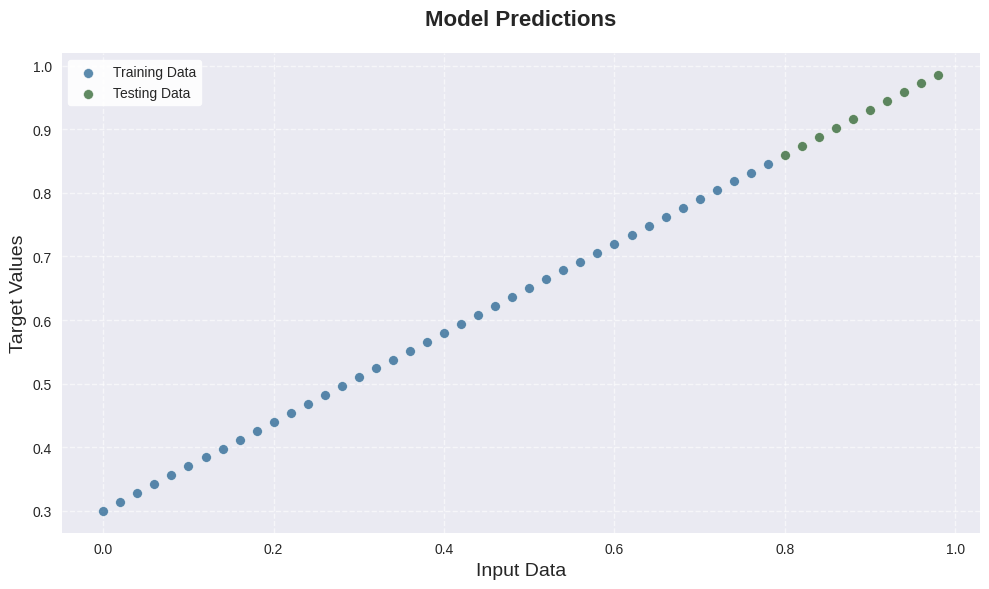

In [5]:
plt.show(plot_predictions(X_train, y_train, X_test, y_test)) ## there are no predictions at the time, so, the function will just plot the data.

## 2. Building the Model


### PyTorch model building essentials

PyTorch has four (give or take) essential modules you can use to create almost any kind of neural network you can imagine.

They are [`torch.nn`](https://pytorch.org/docs/stable/nn.html), [`torch.optim`](https://pytorch.org/docs/stable/optim.html), [`torch.utils.data.Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) and [`torch.utils.data.DataLoader`](https://pytorch.org/docs/stable/data.html). For now, we'll focus on the first two and get to the other two later (though you may be able to guess what they do).

| PyTorch module                                                                                                | What does it do?                                                                                                                                                                                                                                                                                 |
| ------------------------------------------------------------------------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------ |
| [`torch.nn`](https://pytorch.org/docs/stable/nn.html)                                                         | Contains all of the building blocks for computational graphs (essentially a series of computations executed in a particular way).                                                                                                                                                                |
| [`torch.nn.Parameter`](https://pytorch.org/docs/stable/generated/torch.nn.parameter.Parameter.html#parameter) | Stores tensors that can be used with `nn.Module`. If `requires_grad=True` gradients (used for updating model parameters via [**gradient descent**](https://ml-cheatsheet.readthedocs.io/en/latest/gradient_descent.html)) are calculated automatically, this is often referred to as "autograd". |
| [`torch.nn.Module`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module)           | The base class for all neural network modules, all the building blocks for neural networks are subclasses. If you're building a neural network in PyTorch, your models should subclass `nn.Module`. Requires a `forward()` method be implemented.                                                |
| [`torch.optim`](https://pytorch.org/docs/stable/optim.html)                                                   | Contains various optimization algorithms (these tell the model parameters stored in `nn.Parameter` how to best change to improve gradient descent and in turn reduce the loss).                                                                                                                  |
| `def forward()`                                                                                               | All `nn.Module` subclasses require a `forward()` method, this defines the computation that will take place on the data passed to the particular `nn.Module` (e.g. the linear regression formula above).                                                                                          |

If the above sounds complex, think of like this, almost everything in a PyTorch neural network comes from `torch.nn`,

- `nn.Module` contains the larger building blocks (layers)
- `nn.Parameter` contains the smaller parameters like weights and biases (put these together to make `nn.Module`(s))
- `forward()` tells the larger blocks how to make calculations on inputs (tensors full of data) within `nn.Module`(s)
- `torch.optim` contains optimization methods on how to improve the parameters within `nn.Parameter` to better represent input data


In [6]:
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1, dtype=torch.float32))
        self.bias = nn.Parameter(torch.randn(1, dtype=torch.float32))

    def linear(self, X):
        return self.weights * X + self.bias

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear(x)

### Other ways to generate a model

In [7]:
from torch.nn import Sequential
model = Sequential(
    nn.Linear(in_features=30, out_features=13), ## This is an example input layer, 30 in features with our test data will not work.
    nn.Linear(in_features=13, out_features=2),
    nn.Linear(in_features=2, out_features=1)
)

In [8]:
# Instantiate the model
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)

model_0 = LinearRegressionModel()
list(model_0.parameters())
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

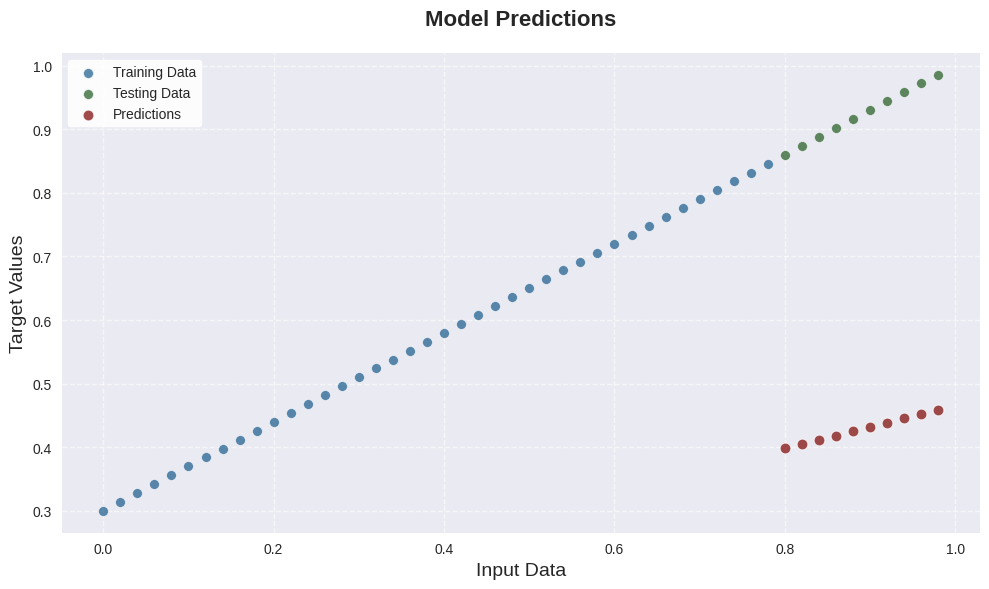

In [9]:
with torch.inference_mode():
    # * Inference mode is used to disable gradient computation, Faster
    # Make predictions
    y_preds = model_0(
        X_test
    )  # * this will call the forward method implicitly, cleaner code.
#                            * __call__ method in pytorch calls forward method and also do some processing as well,
#                            * better practice.
plt.show(plot_predictions(X_train, y_train, X_test, y_test, predictions=y_preds))

## 3. Training the model


### Creating a loss function and optimizer in PyTorch

| Function          | What does it do?                                                                                                                | Where does it live in PyTorch?                                                                                             | Common values                                                                                                                                                                                                                                                                                 |
| ----------------- | ------------------------------------------------------------------------------------------------------------------------------- | -------------------------------------------------------------------------------------------------------------------------- | --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Loss function** | Measures how wrong your models predictions (e.g. `y_preds`) are compared to the truth labels (e.g. `y_test`). Lower the better. | PyTorch has plenty of built-in loss functions in [`torch.nn`](https://pytorch.org/docs/stable/nn.html#loss-functions).     | Mean absolute error (MAE) for regression problems ([`torch.nn.L1Loss()`](https://pytorch.org/docs/stable/generated/torch.nn.L1Loss.html)). Binary cross entropy for binary classification problems ([`torch.nn.BCELoss()`](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html)). |
| **Optimizer**     | Tells your model how to update its internal parameters to best lower the loss.                                                  | You can find various optimization function implementations in [`torch.optim`](https://pytorch.org/docs/stable/optim.html). | Stochastic gradient descent ([`torch.optim.SGD()`](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD)). Adam optimizer ([`torch.optim.Adam()`](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam)).                               |


## Binary Cross Entropy Cost (BCELoss in pytorch)


When labels $y∈{0,1}$ and predicted probabilities $\hat{y}∈(0,1)$:

$$C=−[y⋅log⁡(\hat{y})+(1−y)⋅log⁡(1−\hat{y})]$$


Penalizes heavily for big deviation from the expected value

## KL Divergence as a cost function
There is another cost function useful in predicting Dynamical System : Kullback-Leibler Divergence (KL Divergence)

$$
D_{KL}(P \parallel Q) = \sum_{i} P(i) \log\left( \frac{P(i)}{Q(i)} \right)
$$

Measures how much information is lost when Q is used to approximate P.

In [10]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(model_0.parameters(), lr=0.01)

In [11]:
torch.manual_seed(42)

# Set the number of epochs (how many times the model will pass over the training data)
epochs = 300

# Create empty loss lists to track values
train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):
    ### Training

    # Put model in training mode (this is the default state of a model)
    # Some Layers behave differently in training and evaluation
    model_0.train()

    # 1. Forward pass on train data using the forward() method inside 
    ## Feed Forward method, Mathematically computing the activations of each layer and generating output of the network
    y_pred = model_0(X_train)
    # print(y_pred)

    # 2. Calculate the loss (how different are our models predictions to the ground truth)
    # This is a loss_fn of our choice. Gives out model a function(Values) to minimize
    loss = loss_fn(y_pred, y_train)

    # 3. Zero grad of the optimizer
    ## Removes the gradients of the previous epoch, if any
    optimizer.zero_grad()

    # 4. Loss backwards
    ## backward pass. Propagates the errors backwards. All the tiny nudges that need to be made for better loss.
    loss.backward()

    # 5. Progress the optimizer
    ## Change the weights and biases according to the errors
    optimizer.step()

    ### Testing

    # Put the model in evaluation mode
    model_0.eval()

    with torch.inference_mode():
      # 1. Forward pass on test data
      test_pred = model_0(X_test)

      # 2. Caculate loss on test data
      test_loss = loss_fn(test_pred, y_test.type(torch.float)) # predictions come in torch.float datatype, so comparisons need to be done with tensors of the same type

      # Print out what's happening
      if epoch % 10 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().numpy())
            test_loss_values.append(test_loss.detach().numpy())
            print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss} ")

Epoch: 0 | MAE Train Loss: 0.31288138031959534 | MAE Test Loss: 0.48106518387794495 
Epoch: 10 | MAE Train Loss: 0.1976713240146637 | MAE Test Loss: 0.3463551998138428 
Epoch: 20 | MAE Train Loss: 0.08908725529909134 | MAE Test Loss: 0.21729660034179688 
Epoch: 30 | MAE Train Loss: 0.053148526698350906 | MAE Test Loss: 0.14464017748832703 
Epoch: 40 | MAE Train Loss: 0.04543796554207802 | MAE Test Loss: 0.11360953003168106 
Epoch: 50 | MAE Train Loss: 0.04167863354086876 | MAE Test Loss: 0.09919948130846024 
Epoch: 60 | MAE Train Loss: 0.03818932920694351 | MAE Test Loss: 0.08886633068323135 
Epoch: 70 | MAE Train Loss: 0.03476089984178543 | MAE Test Loss: 0.0805937647819519 
Epoch: 80 | MAE Train Loss: 0.03132382780313492 | MAE Test Loss: 0.07232122868299484 
Epoch: 90 | MAE Train Loss: 0.02788739837706089 | MAE Test Loss: 0.06473556160926819 
Epoch: 100 | MAE Train Loss: 0.024458957836031914 | MAE Test Loss: 0.05646304413676262 
Epoch: 110 | MAE Train Loss: 0.021020207554101944 | MAE

In [18]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

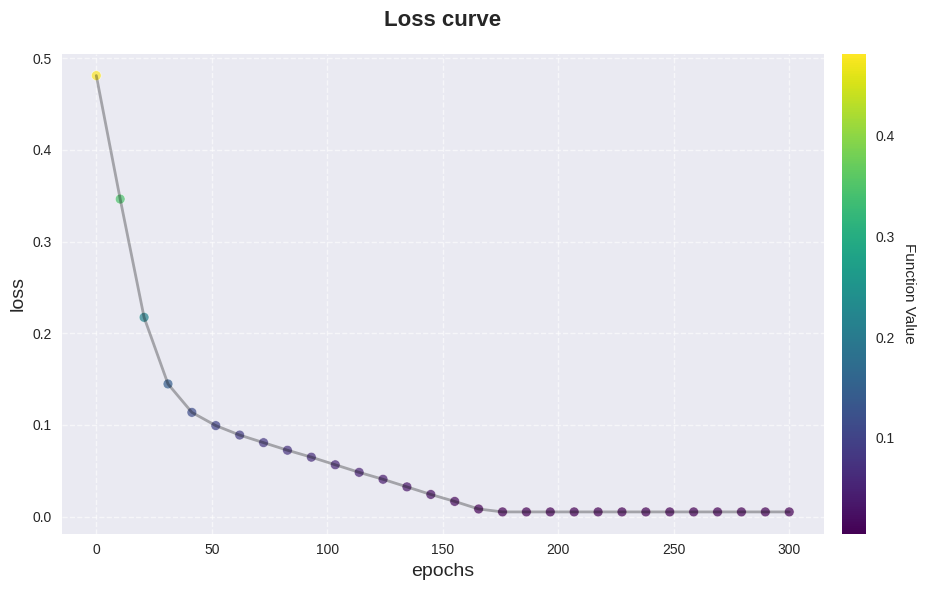

In [19]:
from helper_functions import plot_functions
import numpy as np

plt.show(plot_functions(np.array(test_loss_values), title="Loss curve", xlabel="epochs", ylabel="loss", x_range=(0,epochs)))

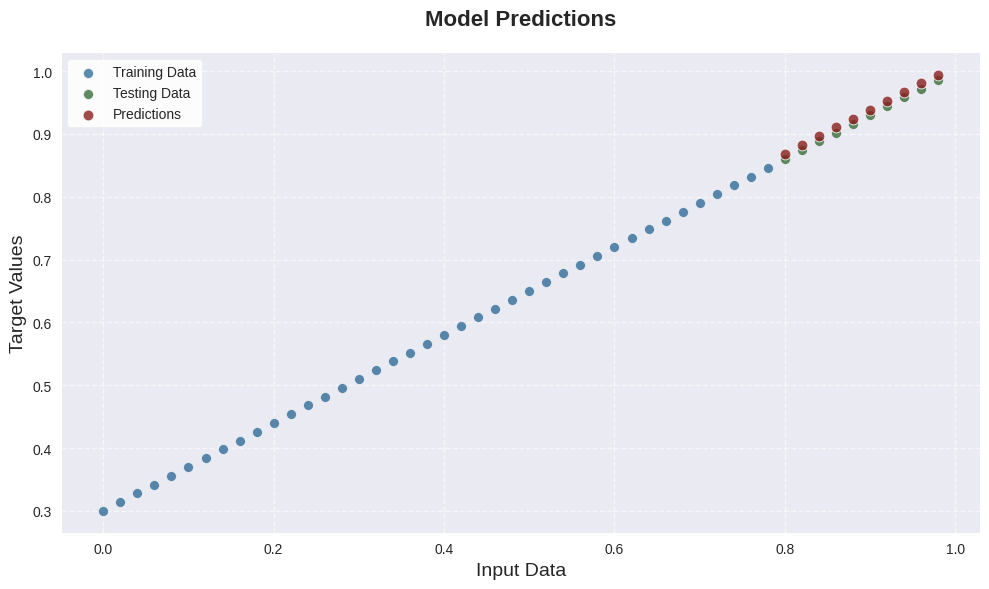

In [14]:
with torch.inference_mode():
    plt.show(plot_predictions(X_train, y_train, X_test, y_test, predictions=model_0(X_test)))

In [ ]:
from pathlib import Path

# 1. Create models directory 
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path 
MODEL_NAME = "LinearModel.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict 
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/LinearModel.pth


In [16]:
model_load = LinearRegressionModel()
model_load.load_state_dict(torch.load(MODEL_SAVE_PATH))

<All keys matched successfully>

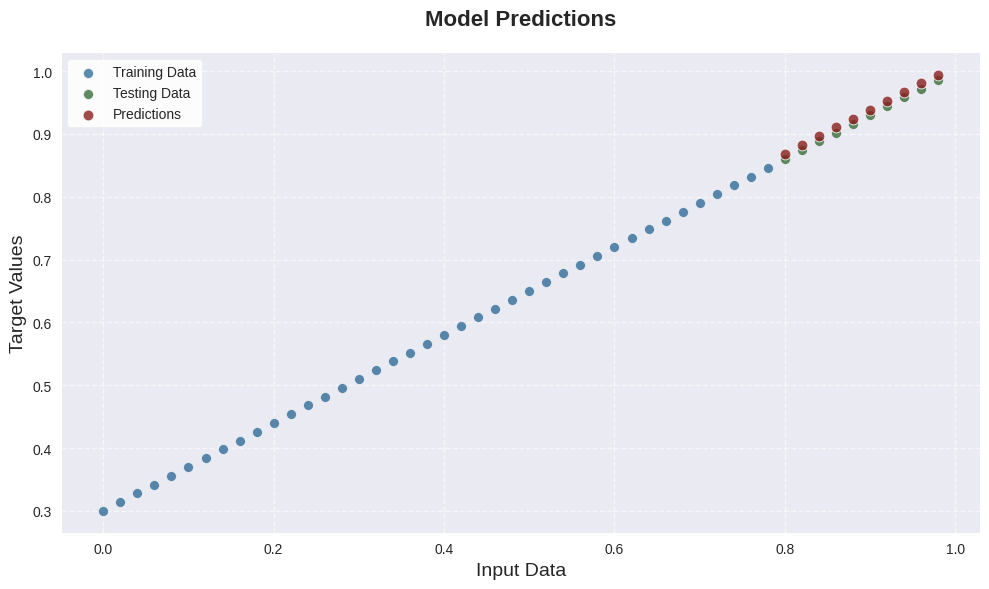

In [17]:
with torch.inference_mode():
    plt.show(plot_predictions(X_train, y_train, X_test, y_test, predictions=model_load(X_test)))